In [1]:
#Status 0 for healthy and Status 1 for PD.
#Name - Subject code name.
#MDVP:Fo(Hz) - Average vocal fundamental frequency
#MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
#MDVP:Flo(Hz) - Minimum vocal fundamental frequency
#MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MD
#VP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from scipy.stats import zscore
from scipy.stats import stats

In [3]:
# Read the data from CSV
pd_data = pd.read_csv("data.csv")

In [4]:
# Print the top 10 rows
pd_data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
# check if there is any null data. As there is no null data this does not require and special processing.
pd_data.isnull().values.any()

False

In [6]:
#Check the shape of the data set
pd_data.shape

(195, 24)

In [7]:
#Number of people with PD and number without. 1 being PD and 0 being healthy
pd_data['status'].value_counts()

1    147
0     48
Name: status, dtype: int64

In [8]:
# Drop the name column as this has no influence on the model.
pd_data = pd_data.drop("name", axis=1)
pd_data.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [9]:
#Remove the outliers from the data where z threshold is less than 3 and print the shape.
z = np.abs(stats.zscore(pd_data))
pd_data = pd_data[(z < 3).all(axis=1)]
pd_data.shape

(181, 23)

In [10]:
#Replace status with relavant labels.
pd_data['status'] = pd_data['status'].replace({0: 'Healthy', 1: 'PD'})

In [11]:
#Check the data types of all the columns.Except for status which is the column to be predicted rest all are float.
pd_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 0 to 194
Data columns (total 23 columns):
MDVP:Fo(Hz)         181 non-null float64
MDVP:Fhi(Hz)        181 non-null float64
MDVP:Flo(Hz)        181 non-null float64
MDVP:Jitter(%)      181 non-null float64
MDVP:Jitter(Abs)    181 non-null float64
MDVP:RAP            181 non-null float64
MDVP:PPQ            181 non-null float64
Jitter:DDP          181 non-null float64
MDVP:Shimmer        181 non-null float64
MDVP:Shimmer(dB)    181 non-null float64
Shimmer:APQ3        181 non-null float64
Shimmer:APQ5        181 non-null float64
MDVP:APQ            181 non-null float64
Shimmer:DDA         181 non-null float64
NHR                 181 non-null float64
HNR                 181 non-null float64
status              181 non-null object
RPDE                181 non-null float64
DFA                 181 non-null float64
spread1             181 non-null float64
spread2             181 non-null float64
D2                  181 non-null fl

In [12]:
#Check the mean, standard devaition and the percentiles for all the Float columns. 
pd_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MDVP:Fo(Hz),181.0,154.676630,41.982512,88.333000,117.274000,149.689000,183.520000,260.105000
MDVP:Fhi(Hz),181.0,183.737436,60.865252,102.145000,133.374000,166.607000,217.455000,450.247000
MDVP:Flo(Hz),181.0,116.235254,43.971398,65.476000,83.961000,104.315000,135.041000,239.170000
MDVP:Jitter(%),181.0,0.005457,0.002959,0.001680,0.003390,0.004760,0.006940,0.018720
MDVP:Jitter(Abs),181.0,0.000039,0.000024,0.000007,0.000020,0.000030,0.000050,0.000120
MDVP:RAP,181.0,0.002839,0.001730,0.000680,0.001650,0.002370,0.003680,0.010750
MDVP:PPQ,181.0,0.003034,0.001769,0.000920,0.001840,0.002580,0.003750,0.011540
Jitter:DDP,181.0,0.008516,0.005187,0.002040,0.004960,0.007100,0.011050,0.032250
MDVP:Shimmer,181.0,0.027603,0.015240,0.009540,0.016420,0.022930,0.035270,0.079590
MDVP:Shimmer(dB),181.0,0.258298,0.150077,0.085000,0.145000,0.210000,0.334000,0.784000


C:\Users\Bhanushree\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


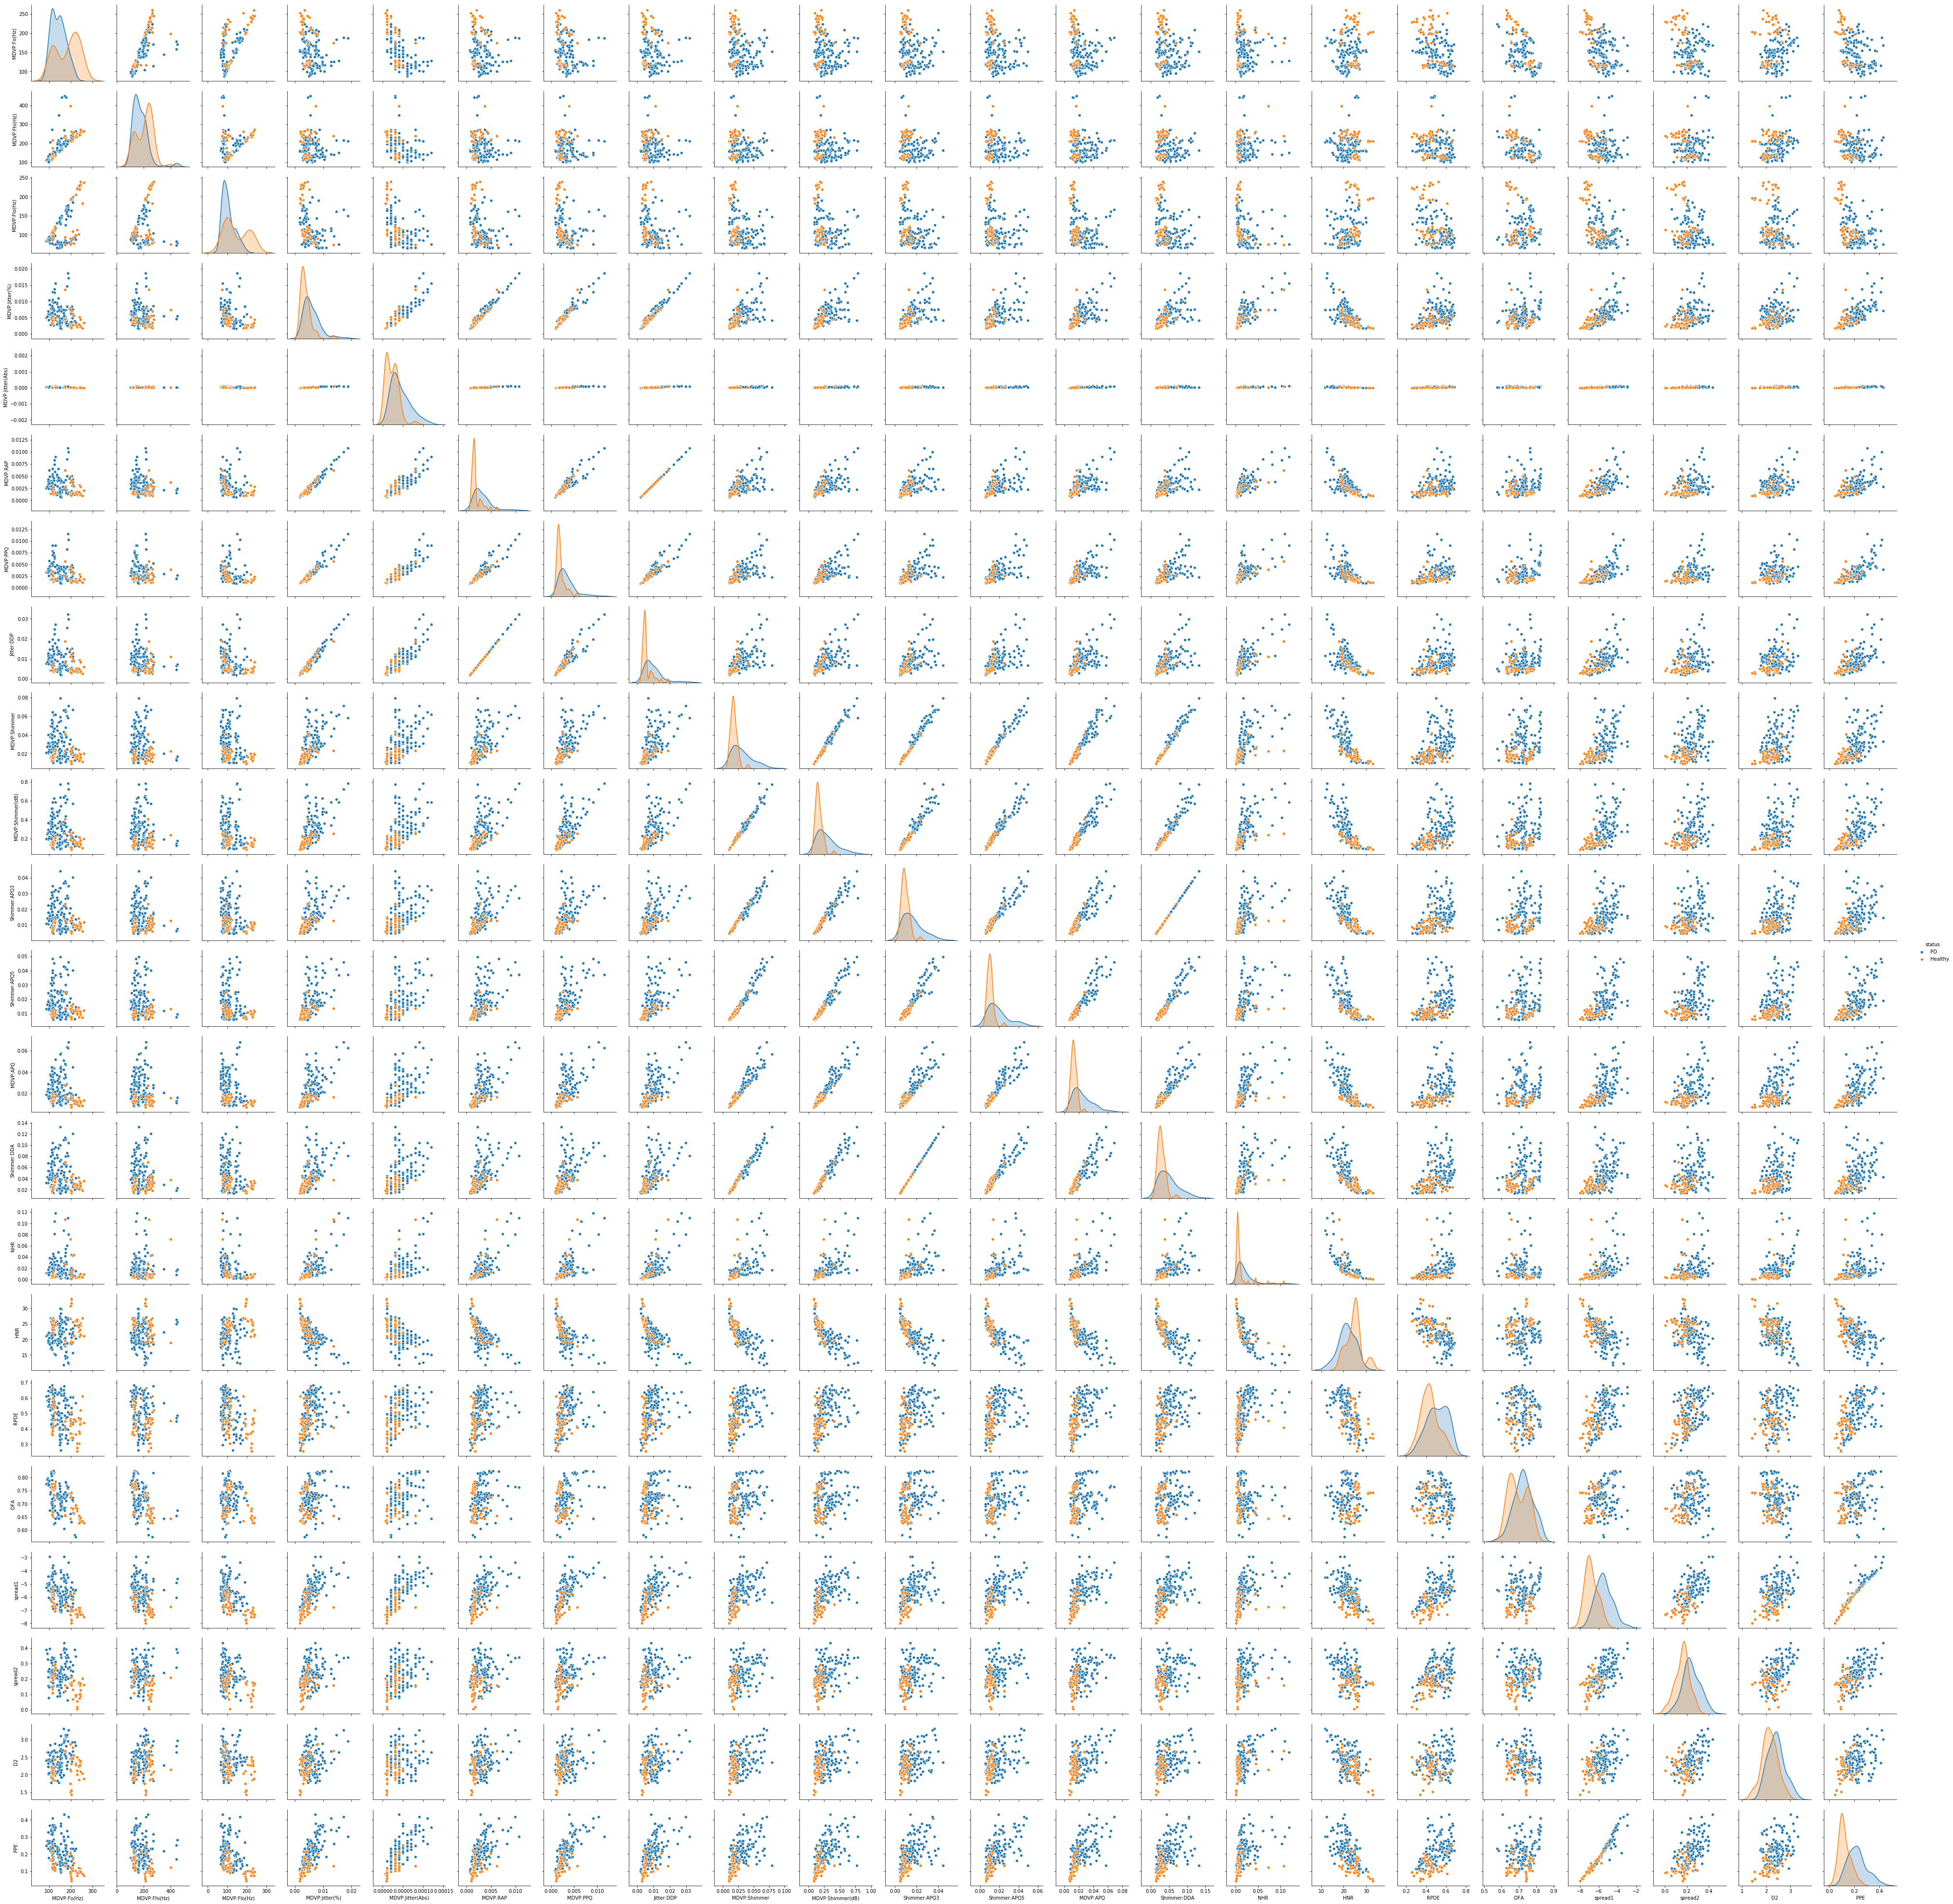

In [13]:
# keeping status as the label to be predicted draw the graph.
import seaborn as sns
sns.pairplot(pd_data,diag_kind='kde', hue = 'status')

In [14]:
# splitting data into training and test set for independent attributes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X =  pd_data.drop("status", axis=1)
y =  pd_data.pop("status")
X_std = StandardScaler().fit_transform(X)
train_set, test_set, train_labels, test_labels = train_test_split(X_std, y, test_size=0.30, random_state=2)

In [15]:
#Use decision tree to predict the model. Here let the model grown model or an overfit model upto the last leaf and maximum depth.
Dt_model = DecisionTreeClassifier(criterion = 'entropy')

In [16]:
# display the important features as recognized by the decision tree. 
Dt_model.fit(train_set,train_labels)
feature_importances = Dt_model.feature_importances_
feature_names = pd_data.columns[0:22]
print(feature_names)
k = 9
top_k_idx = (feature_importances.argsort()[-k:][::-1])
print(feature_names[top_k_idx], feature_importances)

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')
Index(['spread1', 'D2', 'RPDE', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:Fo(Hz)',
       'HNR', 'MDVP:PPQ', 'MDVP:Flo(Hz)'],
      dtype='object') [0.05859767 0.11885852 0.         0.         0.         0.
 0.02077064 0.         0.08644403 0.         0.         0.
 0.         0.         0.         0.05604584 0.12022452 0.
 0.36789942 0.         0.17115935 0.        ]


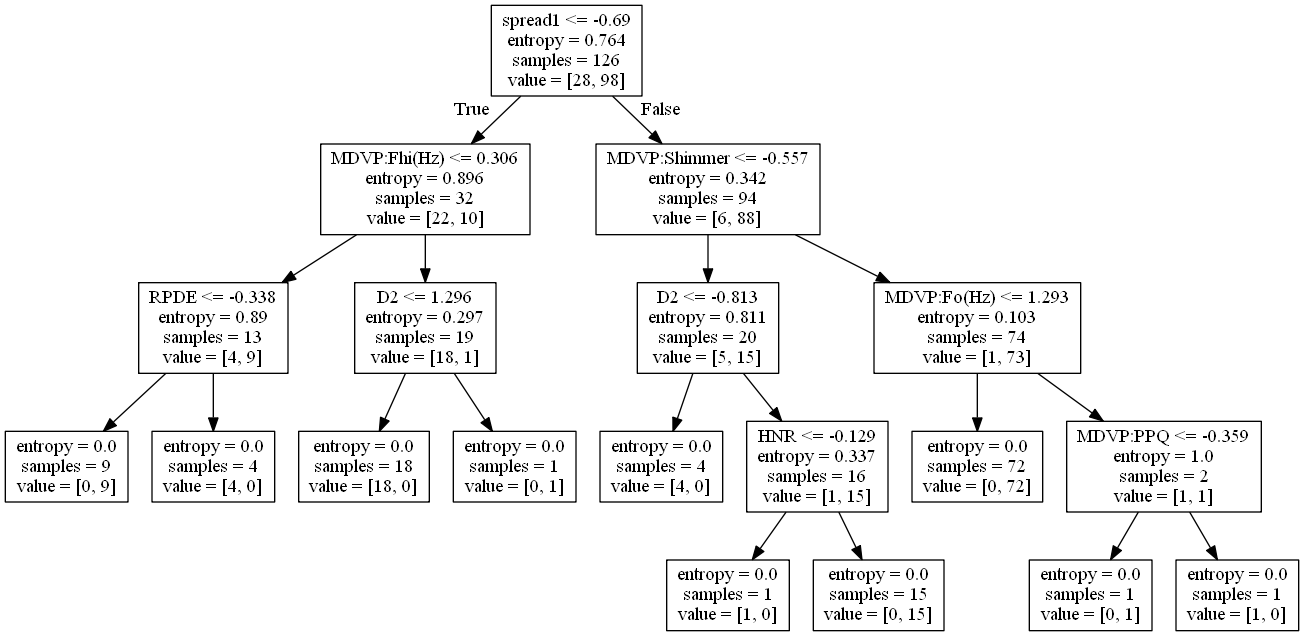

In [17]:
# Print the impage of the decion tree as observed tree as grown until all are predicted correctly. 
#This is an overgrown tree. We can see that the depth of the tree is 4
from sklearn import tree
from os import system
from IPython.display import Image 
dotfilee = open('pd_tree1.dot','w')
tree.export_graphviz(Dt_model, out_file = dotfilee, feature_names = X.columns)
dotfilee.close()
system("dot -Tpng pd_tree1.dot -o mpg_tree.png")
Image(r"C:\Users\Bhanushree\Downloads\PGAIML\Supervised learning project 2\mpg_tree.png")

In [18]:
# Predict the accuracy on the training data set. Since this is an over fit model the accuracy is 100%
y_predict1_Dt=Dt_model.predict(train_set)
Dt_acc1=metrics.accuracy_score(train_labels,y_predict1_Dt)
print(Dt_acc1)

1.0


In [19]:
# Predict the model on the test data set 
y_predict_Dt=Dt_model.predict(test_set)
y_predict_Dt

array(['Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'PD', 'PD', 'PD', 'PD', 'PD', 'PD', 'Healthy', 'PD', 'PD',
       'Healthy', 'PD', 'Healthy', 'PD', 'Healthy', 'PD', 'PD', 'PD',
       'PD', 'PD', 'PD', 'Healthy', 'PD', 'PD', 'PD', 'PD', 'Healthy',
       'PD', 'PD', 'PD', 'Healthy', 'PD', 'Healthy', 'PD', 'PD', 'PD',
       'PD', 'PD', 'PD', 'PD', 'Healthy', 'PD', 'PD', 'Healthy', 'PD',
       'Healthy', 'PD', 'Healthy', 'PD', 'PD'], dtype=object)

In [20]:
# Predict the accuracy on the test data set.
Dt_acc=metrics.accuracy_score(test_labels,y_predict_Dt)
print(Dt_acc)

0.8181818181818182


In [21]:
# Print the classification report.
Dt_cr=metrics.classification_report(test_labels , y_predict_Dt)
print(Dt_cr)

              precision    recall  f1-score   support

     Healthy       0.72      0.72      0.72        18
          PD       0.86      0.86      0.86        37

   micro avg       0.82      0.82      0.82        55
   macro avg       0.79      0.79      0.79        55
weighted avg       0.82      0.82      0.82        55



In [22]:
# Build a new model with max depth as 3
Dt_model1 = DecisionTreeClassifier(criterion = 'entropy',max_depth=3,random_state=0)

In [23]:
# Print the important features.
Dt_model1.fit(train_set,train_labels)
feature_importances = Dt_model1.feature_importances_
feature_names = pd_data.columns[0:22]
print(feature_names)
k = 9
top_k_idx = (feature_importances.argsort()[-k:][::-1])
print(feature_names[top_k_idx], feature_importances)

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')
Index(['PPE', 'D2', 'MDVP:APQ', 'MDVP:Fhi(Hz)', 'MDVP:Shimmer', 'MDVP:Fo(Hz)',
       'HNR', 'NHR', 'Shimmer:DDA'],
      dtype='object') [0.06347348 0.12874853 0.         0.         0.         0.
 0.         0.         0.09363689 0.         0.         0.
 0.13022819 0.         0.         0.         0.         0.
 0.         0.         0.18540122 0.39851169]


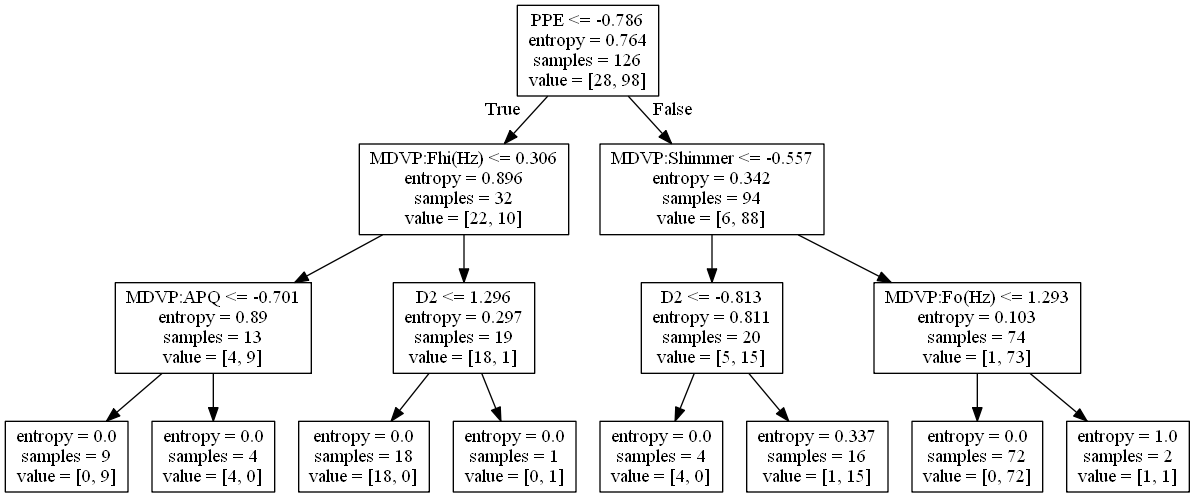

In [24]:
# Print the tree image. We can see that the tree has grown upto 3 hierarchy.
from sklearn import tree
from os import system
dotfileee = open('pd_tree2.dot','w')
tree.export_graphviz(Dt_model1, out_file = dotfileee, feature_names = X.columns)
dotfileee.close()
system("dot -Tpng pd_tree2.dot -o mpg_tree1.png")
Image(r"C:\Users\Bhanushree\Downloads\PGAIML\Supervised learning project 2\mpg_tree1.png")

In [25]:
y_predict_Dt1=Dt_model1.predict(test_set)
y_predict_Dt1

array(['Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'PD', 'PD', 'PD', 'PD', 'PD', 'PD', 'PD', 'PD', 'PD', 'Healthy',
       'PD', 'Healthy', 'PD', 'Healthy', 'PD', 'PD', 'Healthy', 'PD',
       'PD', 'Healthy', 'Healthy', 'PD', 'PD', 'PD', 'PD', 'Healthy',
       'PD', 'PD', 'PD', 'Healthy', 'PD', 'Healthy', 'PD', 'PD', 'PD',
       'PD', 'PD', 'PD', 'PD', 'Healthy', 'PD', 'Healthy', 'Healthy',
       'PD', 'Healthy', 'PD', 'Healthy', 'PD', 'PD'], dtype=object)

In [26]:
# Predict the accuracy of the model on the test data set..
Dt_acc2=metrics.accuracy_score(test_labels,y_predict_Dt1)
print(Dt_acc2)

0.7818181818181819


In [27]:
Dt_cr1=metrics.classification_report(test_labels , y_predict_Dt1)
print(Dt_cr1)

              precision    recall  f1-score   support

     Healthy       0.65      0.72      0.68        18
          PD       0.86      0.81      0.83        37

   micro avg       0.78      0.78      0.78        55
   macro avg       0.75      0.77      0.76        55
weighted avg       0.79      0.78      0.78        55



In [28]:
# Build a random forrest model. We can see that the acccuracy of the random forest model has increased.
# Here we are training the model with 3 decision trees.
Rf_model = RandomForestClassifier(n_estimators=3,criterion='entropy',max_depth=3,random_state=0 )
Rf_model.fit(train_set, train_labels)
y_predict_Rf=Rf_model.predict(test_set)
Rf_acc=metrics.accuracy_score(test_labels,y_predict_Rf)
print ("Random forrest model accuracy for 3 decision tree",(Rf_acc))

Random forrest model accuracy for 3 decision tree 0.8363636363636363


In [29]:
# Now using decsion tree let us try bagging using 100 decision trees
bg = BaggingClassifier(DecisionTreeClassifier(), max_samples = 0.8, max_features = 1.0, n_estimators=100)
bg.fit(train_set, train_labels)
y_predict_bag=bg.predict(test_set)
bg_acc=metrics.accuracy_score(test_labels,y_predict_bag)
print("Bagging model accuracy for 100 decision tree",(bg_acc))

Bagging model accuracy for 100 decision tree 0.8545454545454545


In [30]:
# Now using decsion tree let us try adaboost using 20 decision trees
ada = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=20, learning_rate=1)
ada.fit(train_set, train_labels)
y_predict_ada=ada.predict(test_set)
ada_acc=metrics.accuracy_score(test_labels,y_predict_ada)
print ("Ada Boost model accuracy for 200 decision tree",(ada_acc))

Ada Boost model accuracy for 200 decision tree 0.8363636363636363


In [31]:
# Build a random forrest model. We can see that the acccuracy of the random forest model has increased.
# Here we are training the model with 200 decision trees.
# 200 decision trees is the optimal number of trees that gives the best result
Rf_model = RandomForestClassifier(n_estimators=200,criterion='entropy',max_depth=200,random_state=0 )
Rf_model.fit(train_set, train_labels)
y_predict_Rf=Rf_model.predict(test_set)
Rf_acc=metrics.accuracy_score(test_labels,y_predict_Rf)
print ("Random forrest model accuracy for 200 decision tree",(Rf_acc))

Random forrest model accuracy for 200 decision tree 0.8727272727272727
